In [1]:
!nvidia-smi

Sat Mar 15 05:14:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.03             Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P4              8W /   35W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)
GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([64, 28])
net.0.bias: torch.Size([64])
net.2.weight: torch.Size([64, 64])
net.2.bias: torch.Size([64])
net.4.weight: torch.Size([2, 64])
net.4.bias: torch.Size([2])
Epoch 1/25: Training Loss: 0.6053 | Training Accuracy: 66.68% | Validation Loss: 0.5801 | Validation Accuracy: 69.38% | LR: 0.001000 | Epoch Time: 32.50 sec
Epoch 2/25: Training Loss: 0.5725 | Training Accuracy: 69.83% | Validation Loss: 0.5600 | Validation Accuracy: 70.79% | LR: 0.001000 | Epoch Time: 32.23 sec
Epoch 3/25: Training 

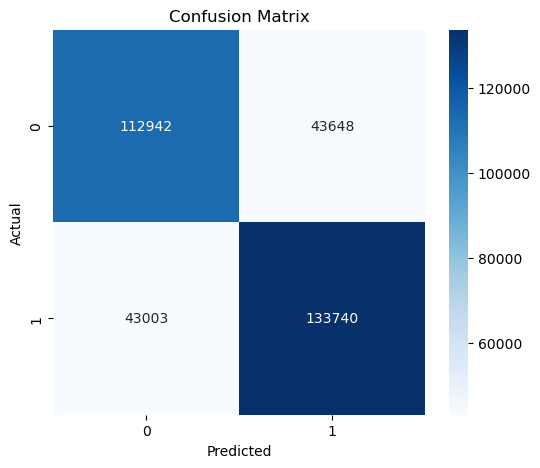

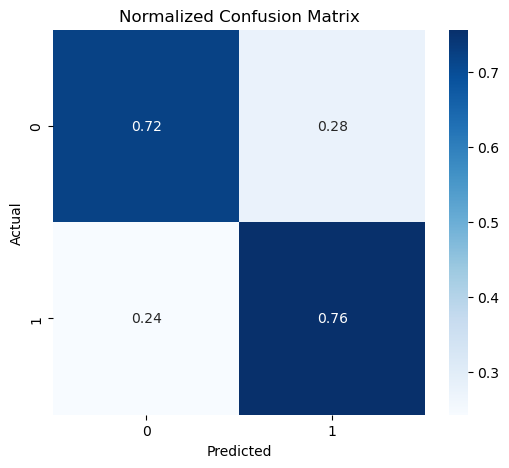

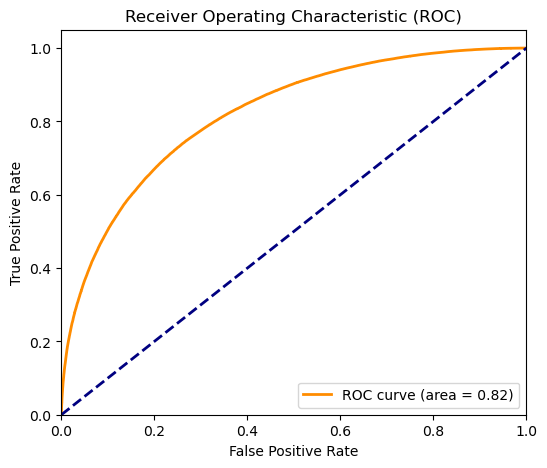

ROC AUC Score: 0.8200
CPU times: user 13min 10s, sys: 1min 59s, total: 15min 10s
Wall time: 14min 23s


In [2]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Splitting
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (e.g., 80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 64      # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # can improve performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Epoch-level Logging
# ---------------------------
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    epoch_start_time = time.time()
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    epoch_time = time.time() - epoch_start_time
    
    # Get current learning rate (assuming one parameter group)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary in a single line
    print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.2f}% | "
          f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}% | LR: {current_lr:.6f} | "
          f"Epoch Time: {epoch_time:.2f} sec")

# ---------------------------
# 7. Evaluate on Test Set and Compute Metrics
# ---------------------------
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        # Calculate probabilities using softmax; take probability of class "1"
        probs = nn.functional.softmax(outputs, dim=1)
        all_test_probs.extend(probs[:, 1].cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("Test Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
# Compute ROC AUC Score
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([128, 28])
net.0.bias: torch.Size([128])
net.2.weight: torch.Size([128, 128])
net.2.bias: torch.Size([128])
net.4.weight: torch.Size([128, 128])
net.4.bias: torch.Size([128])
net.6.weight: torch.Size([2, 128])
net.6.bias: torch.Size([2])


Epoch 1/25: Training Loss: 0.6005 | Training Accuracy: 67.01% | Training ROC AUC: 0.7347 | Val Loss: 0.5772 | Val Accuracy: 69.62% | Val ROC AUC: 0.7675 | LR: 0.001000 | Epoch T

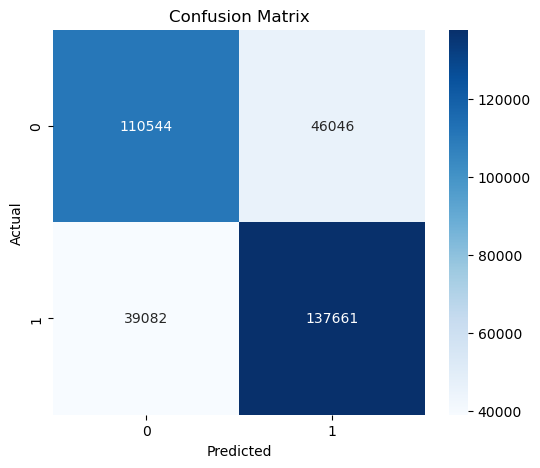

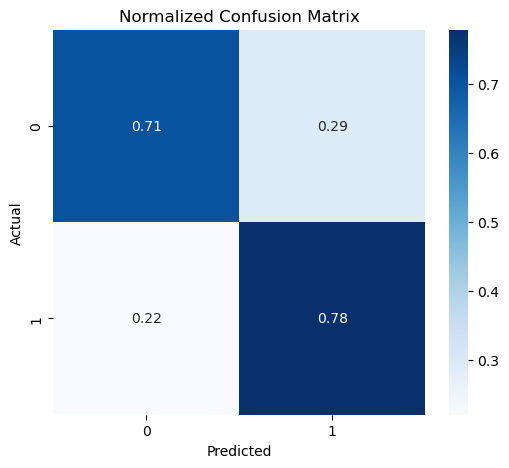

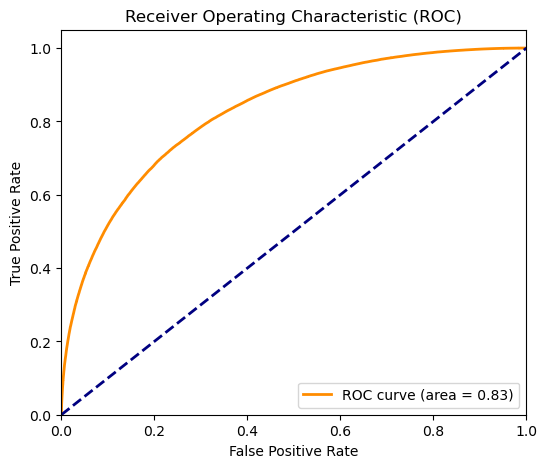

ROC AUC Score: 0.8264
CPU times: user 14min 10s, sys: 2min 10s, total: 16min 20s
Wall time: 15min 28s


In [6]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Splitting
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (e.g., 80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # New hidden layer added
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


input_dim  = len(feature_columns)
hidden_dim = 128      # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # can improve performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Epoch-level Logging
# ---------------------------
num_epochs = 25

for epoch in range(num_epochs):
    # ---------------------------
    # Training Phase
    # ---------------------------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_labels_epoch = []
    train_probs_epoch = []
    epoch_start_time = time.time()
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
        
        # Detach before converting to NumPy
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        train_probs_epoch.extend(probs.detach().cpu().numpy())
        train_labels_epoch.extend(y_batch.cpu().numpy())
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    try:
        train_roc_auc = roc_auc_score(train_labels_epoch, train_probs_epoch)
    except ValueError:
        train_roc_auc = float('nan')
    
    # ---------------------------
    # Validation Phase
    # ---------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels_epoch = []
    val_probs_epoch = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs_epoch.extend(probs.detach().cpu().numpy())
            val_labels_epoch.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels_epoch, val_probs_epoch)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary including ROC AUC scores for training and validation
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.2f}% | Training ROC AUC: {train_roc_auc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} | "
          f"LR: {current_lr:.6f} | Epoch Time: {epoch_time:.2f} sec")

# ---------------------------
# 7. Evaluate on Test Set and Compute Metrics
# ---------------------------
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        # Calculate probabilities using softmax; take probability of class "1"
        probs = nn.functional.softmax(outputs, dim=1)
        all_test_probs.extend(probs[:, 1].cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("Test Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
# Compute ROC AUC Score
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([128, 28])
net.0.bias: torch.Size([128])
net.2.weight: torch.Size([128, 128])
net.2.bias: torch.Size([128])
net.4.weight: torch.Size([128, 128])
net.4.bias: torch.Size([128])
net.6.weight: torch.Size([128, 128])
net.6.bias: torch.Size([128])
net.8.weight: torch.Size([2, 128])
net.8.bias: torch.Size([2])


Epoch 1/25: Train Loss: 0.5976 |

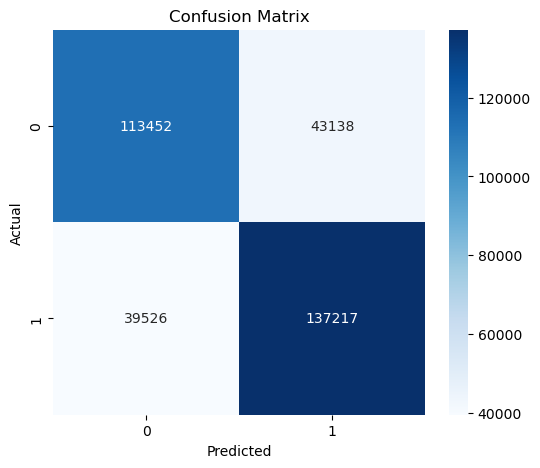

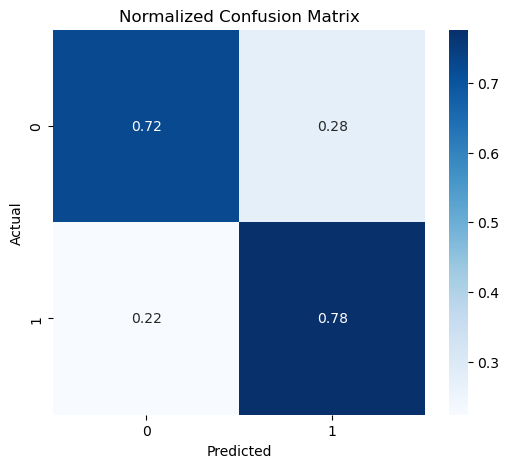

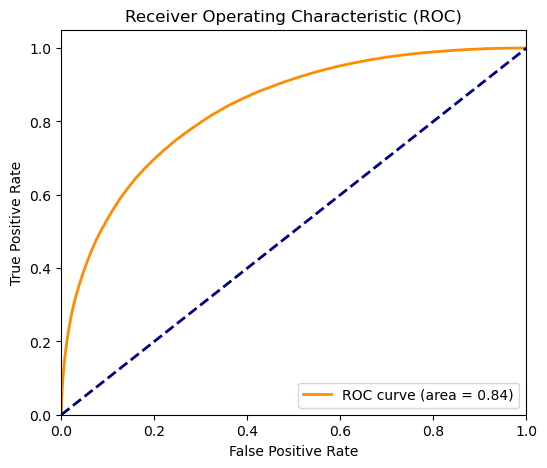

ROC AUC Score: 0.8352
CPU times: user 9min 12s, sys: 1min 26s, total: 10min 39s
Wall time: 9min 43s


In [10]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Splitting
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 128      # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # improves performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
initial_lr = 0.001
min_lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Dynamic LR and Model Saving
# ---------------------------
num_epochs = 25
best_val_roc_auc = 0.0

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation loop with ROC AUC calculation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            # Get probability for the positive class (class index 1)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Check for improvement in validation ROC AUC
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
    else:
        # No improvement: reduce learning rate if above minimum
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=144, bias=True)
    (1): ReLU()
    (2): Linear(in_features=144, out_features=144, bias=True)
    (3): ReLU()
    (4): Linear(in_features=144, out_features=144, bias=True)
    (5): ReLU()
    (6): Linear(in_features=144, out_features=144, bias=True)
    (7): ReLU()
    (8): Linear(in_features=144, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([144, 28])
net.0.bias: torch.Size([144])
net.2.weight: torch.Size([144, 144])
net.2.bias: torch.Size([144])
net.4.weight: torch.Size([144, 144])
net.4.bias: torch.Size([144])
net.6.weight: torch.Size([144, 144])
net.6.bias: torch.Size([144])
net.8.weight: torch.Size([2, 144])
net.8.bias: torch.Size([2])


Epoch 1/25: Train Loss: 0.5967 |

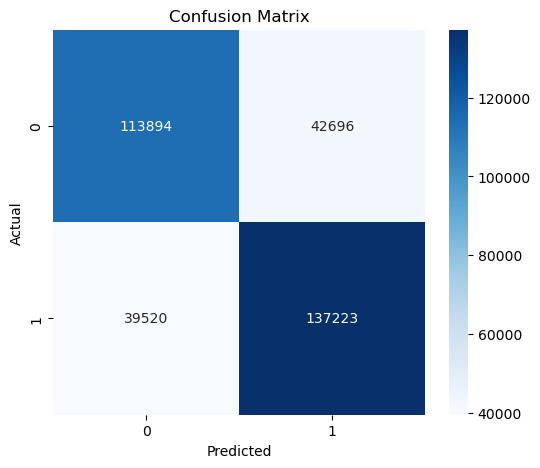

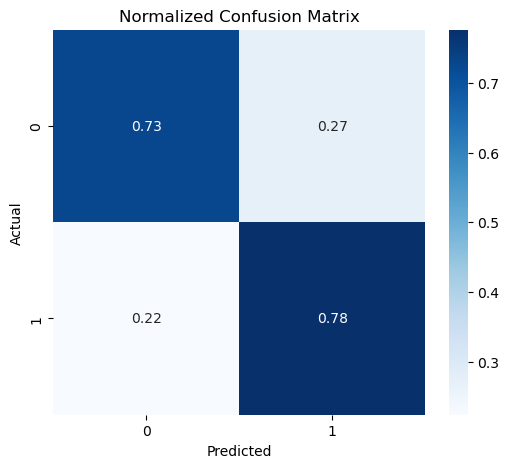

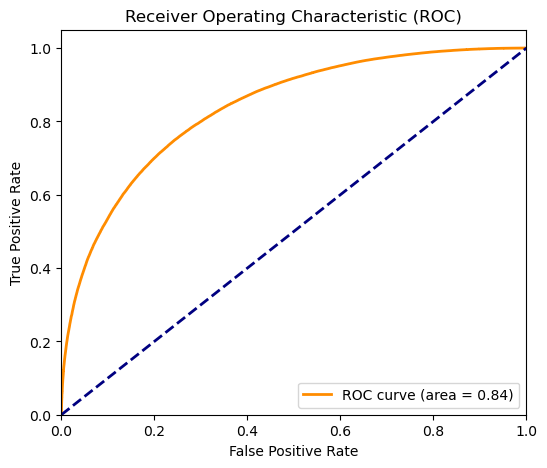

ROC AUC Score: 0.8361
CPU times: user 12min 55s, sys: 2min 1s, total: 14min 57s
Wall time: 14min 4s


In [16]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Splitting
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 144      # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # improves performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
initial_lr = 0.001
min_lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Dynamic LR and Model Saving
# ---------------------------
num_epochs = 25
best_val_roc_auc = 0.0

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation loop with ROC AUC calculation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            # Get probability for the positive class (class index 1)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Check for improvement in validation ROC AUC
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
    else:
        # No improvement: reduce learning rate if above minimum
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([128, 28])
net.0.bias: torch.Size([128])
net.2.weight: torch.Size([128, 128])
net.2.bias: torch.Size([128])
net.4.weight: torch.Size([128, 128])
net.4.bias: torch.Size([128])
net.6.weight: torch.Size([128, 128])
net.6.bias: torch.Size([128])
net.8.weight: torch.Size([2, 128])
net.8.bias: torch.Size([2])


Epoch 1/25: Train Loss: 0.5974 |

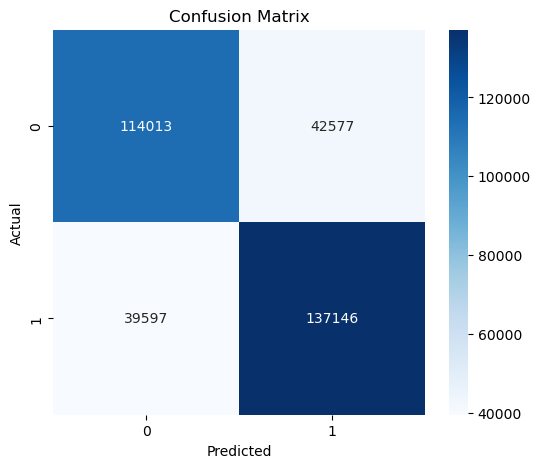

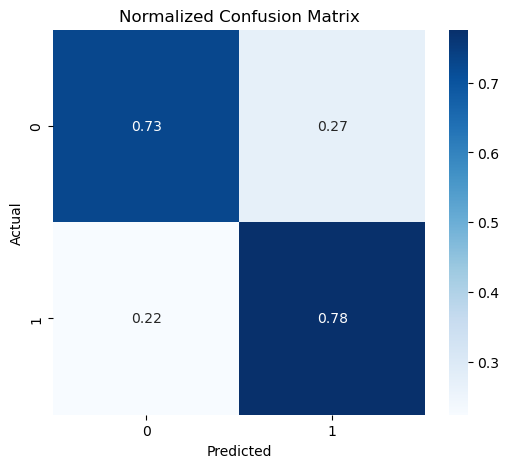

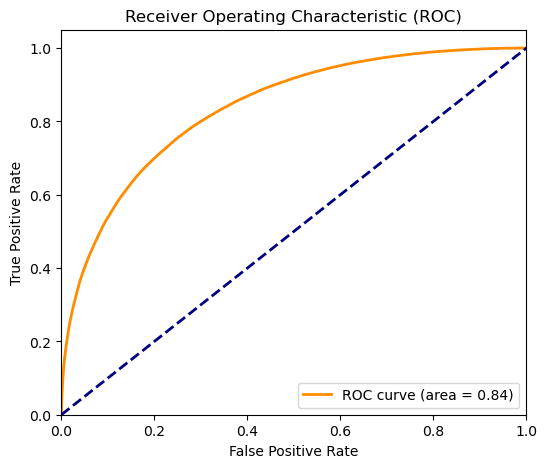

ROC AUC Score: 0.8362
CPU times: user 16min 3s, sys: 2min 35s, total: 18min 39s
Wall time: 17min 50s


In [19]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Splitting
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 128      # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # improves performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
initial_lr = 0.001
min_lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Dynamic LR and Model Saving
# ---------------------------
num_epochs = 25
best_val_roc_auc = 0.0

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation loop with ROC AUC calculation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            # Get probability for the positive class (class index 1)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Check for improvement in validation ROC AUC
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
    else:
        # No improvement: reduce learning rate if above minimum
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([64, 28])
net.0.bias: torch.Size([64])
net.2.weight: torch.Size([128, 64])
net.2.bias: torch.Size([128])
net.4.weight: torch.Size([128, 128])
net.4.bias: torch.Size([128])
net.6.weight: torch.Size([64, 128])
net.6.bias: torch.Size([64])
net.8.weight: torch.Size([2, 64])
net.8.bias: torch.Size([2])


Epoch 1/1000: Train Loss: 0.5982 | Train A

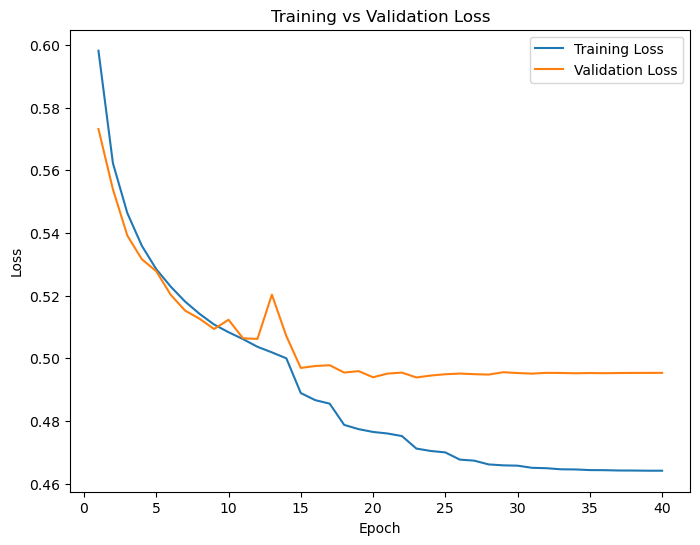

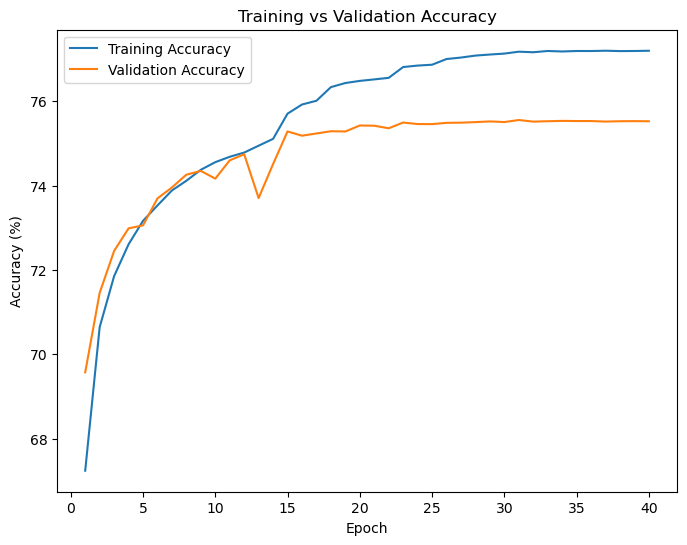

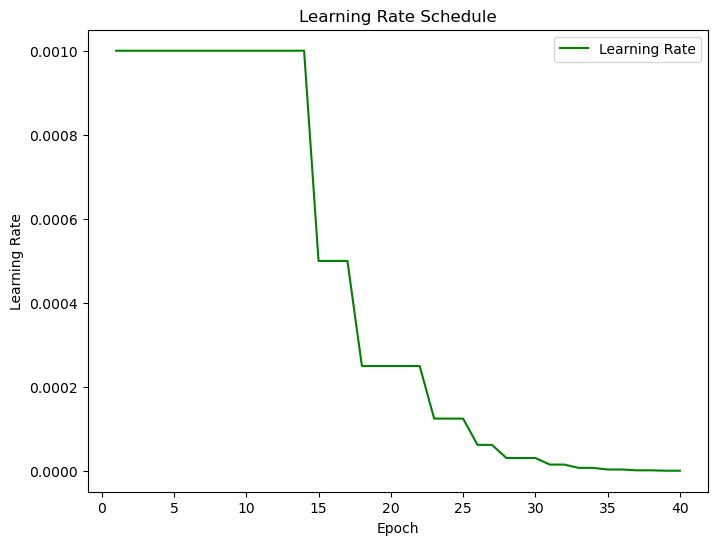


Test Set Evaluation:
  Test Loss: 0.4966
  Test Accuracy: 75.38%

Classification Report:
              precision    recall  f1-score   support

           0     0.7474    0.7188    0.7328    156590
           1     0.7590    0.7848    0.7717    176743

    accuracy                         0.7538    333333
   macro avg     0.7532    0.7518    0.7523    333333
weighted avg     0.7536    0.7538    0.7534    333333



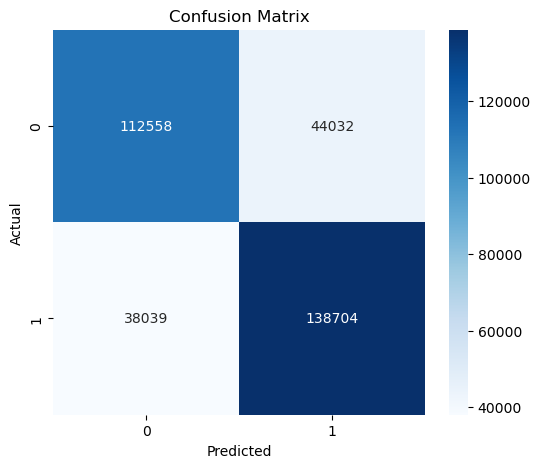

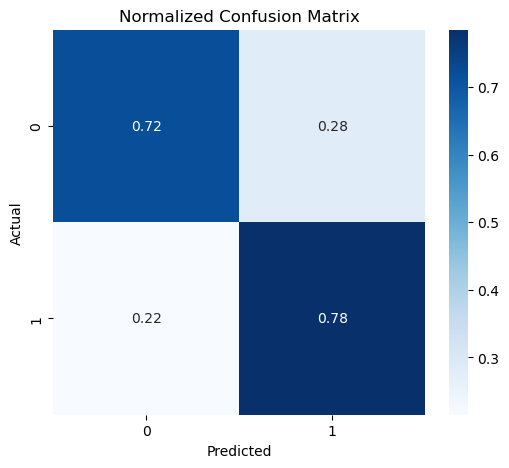

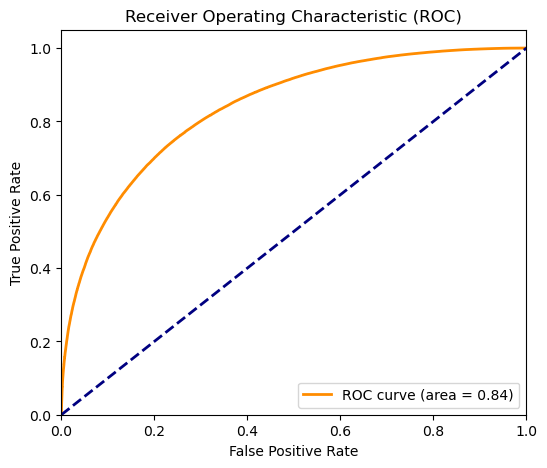

ROC AUC Score: 0.8369
CPU times: user 25min 2s, sys: 3min 13s, total: 28min 16s
Wall time: 26min 38s


In [3]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Splitting
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
# Note: hidden_dim1, hidden_dim2, hidden_dim3 are defined as globals and used in the model.
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 64      # adjust as needed
hidden_dim1 = 128    # adjust as needed
hidden_dim2 = 128    # adjust as needed
hidden_dim3 = 64     # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # improves performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
initial_lr = 0.001
min_lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")


# ---------------------------
# 6. Training Loop with Dynamic LR Reduction (patience = 1)
# ---------------------------

num_epochs = 1000
best_val_roc_auc = 0.0

# Initialize lists for storing metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lrs = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation loop with ROC AUC calculation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    lrs.append(current_lr)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Check for improvement in validation ROC AUC and adjust LR if no improvement in this epoch
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
    else:
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break


# ---------------------------
# Plotting the Metrics
# ---------------------------
epochs_range = range(1, len(train_losses) + 1)

# Plot 1: Training Loss vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot 2: Training Accuracy vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot 3: Learning Rate Schedule
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, lrs, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


---
# Standard Scaling
---

Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([64, 28])
net.0.bias: torch.Size([64])
net.2.weight: torch.Size([128, 64])
net.2.bias: torch.Size([128])
net.4.weight: torch.Size([128, 128])
net.4.bias: torch.Size([128])
net.6.weight: torch.Size([64, 128])
net.6.bias: torch.Size([64])
net.8.weight: torch.Size([2, 64])
net.8.bias: torch.Size([2])


Epoch 1/1000: Train Loss: 0.5564 | Train A

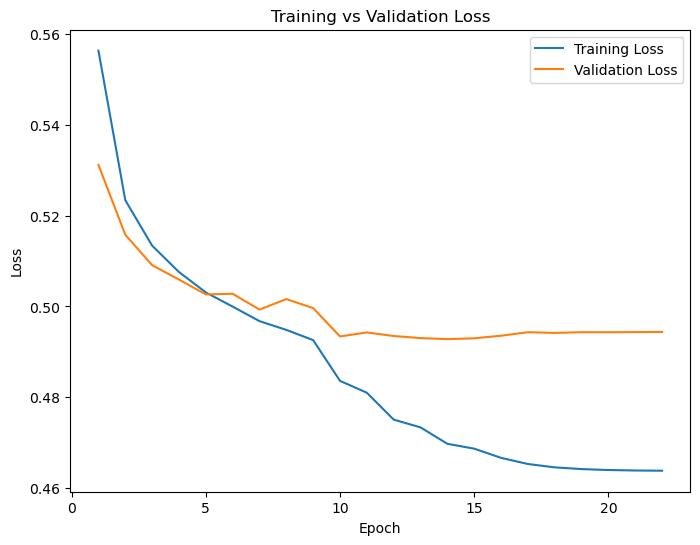

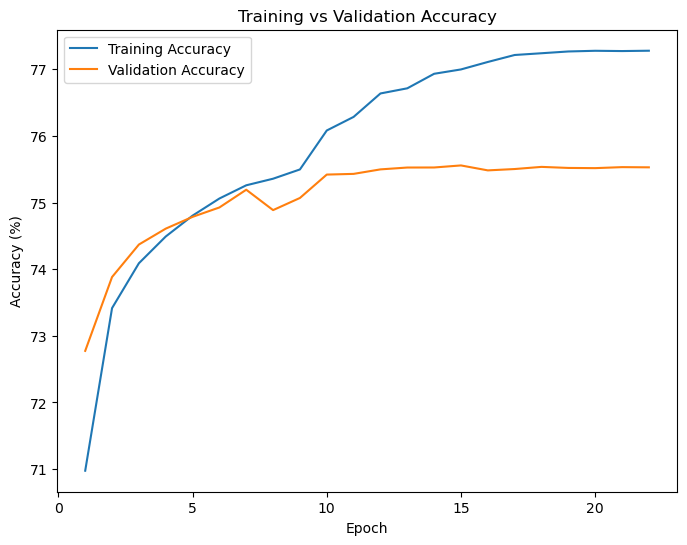

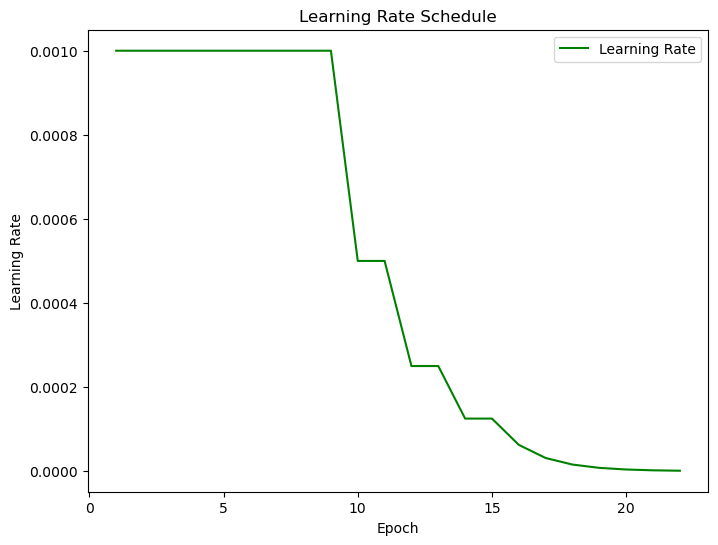


Test Set Evaluation:
  Test Loss: 0.4949
  Test Accuracy: 75.45%

Classification Report:
              precision    recall  f1-score   support

           0     0.7395    0.7372    0.7383    156590
           1     0.7678    0.7699    0.7688    176743

    accuracy                         0.7545    333333
   macro avg     0.7536    0.7535    0.7536    333333
weighted avg     0.7545    0.7545    0.7545    333333



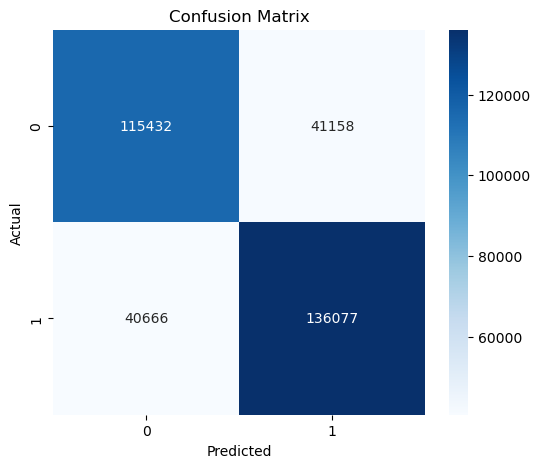

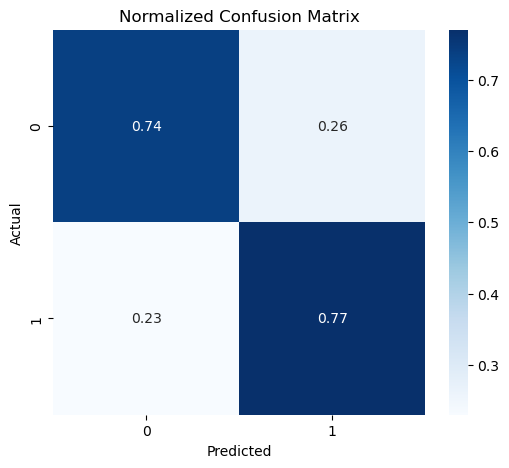

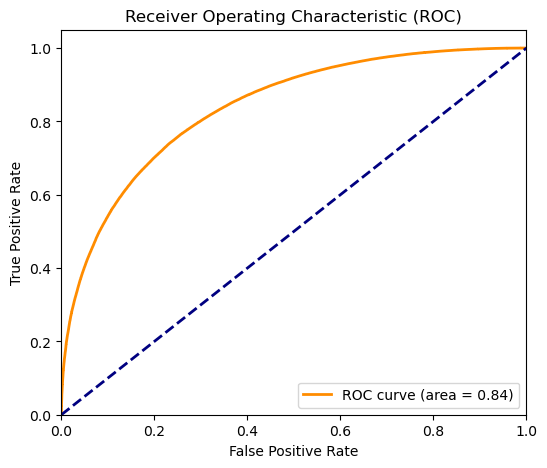

ROC AUC Score: 0.8376
CPU times: user 9min 40s, sys: 1min 14s, total: 10min 54s
Wall time: 10min 1s


In [7]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading, Splitting, and Scaling
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Scale features using StandardScaler
scaler = StandardScaler()
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
val_data[feature_columns]   = scaler.transform(val_data[feature_columns])
test_pd[feature_columns]    = scaler.transform(test_pd[feature_columns])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
# Note: hidden_dim1, hidden_dim2, hidden_dim3 are defined as globals and used in the model.
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 64      # adjust as needed
hidden_dim1 = 128    # adjust as needed
hidden_dim2 = 128    # adjust as needed
hidden_dim3 = 64     # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # improves performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
initial_lr = 0.001
min_lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Dynamic LR Reduction (patience = 1)
# ---------------------------
num_epochs = 1000
best_val_roc_auc = 0.0

# Initialize lists for storing metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lrs = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation loop with ROC AUC calculation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    lrs.append(current_lr)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Check for improvement in validation ROC AUC and adjust LR if no improvement in this epoch
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
    else:
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break

# ---------------------------
# Plotting the Metrics
# ---------------------------
epochs_range = range(1, len(train_losses) + 1)

# Plot 1: Training Loss vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot 2: Training Accuracy vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot 3: Learning Rate Schedule
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, lrs, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([64, 28])
net.0.bias: torch.Size([64])
net.2.weight: torch.Size([128, 64])
net.2.bias: torch.Size([128])
net.4.weight: torch.Size([128, 128])
net.4.bias: torch.Size([128])
net.6.weight: torch.Size([64, 128])
net.6.bias: torch.Size([64])
net.8.weight: torch.Size([2, 64])
net.8.bias: torch.Size([2])


Epoch 1/1000: Train Loss: 0.5582 | Train A

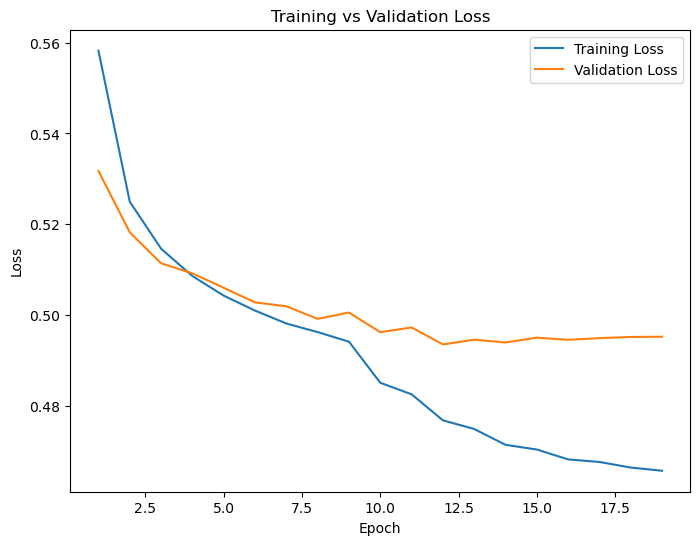

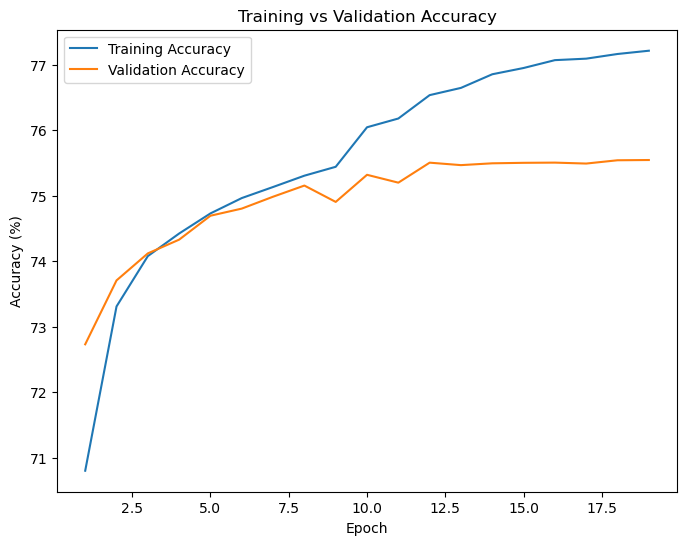

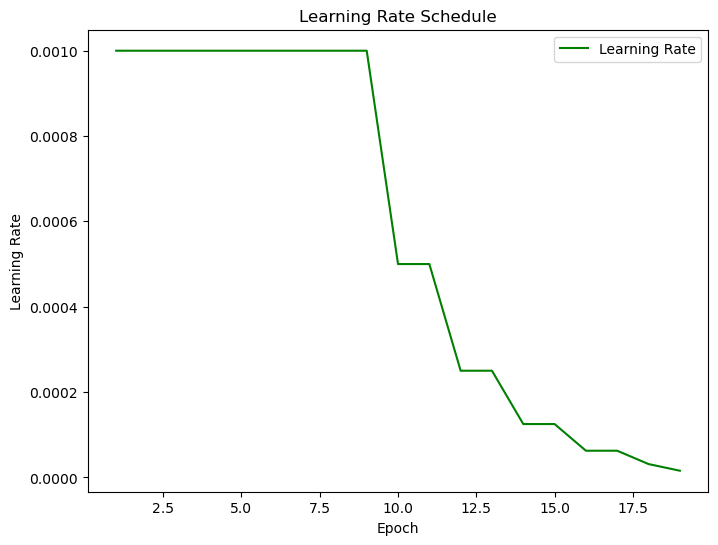


Test Set Evaluation:
  Test Loss: 0.4970
  Test Accuracy: 75.31%

Classification Report:
              precision    recall  f1-score   support

           0     0.7405    0.7305    0.7354    156590
           1     0.7640    0.7732    0.7686    176743

    accuracy                         0.7531    333333
   macro avg     0.7523    0.7518    0.7520    333333
weighted avg     0.7530    0.7531    0.7530    333333



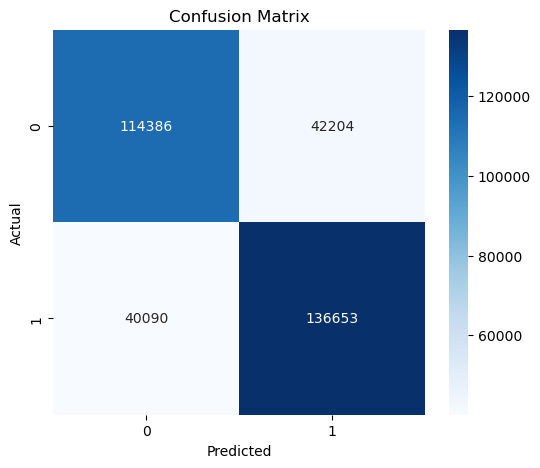

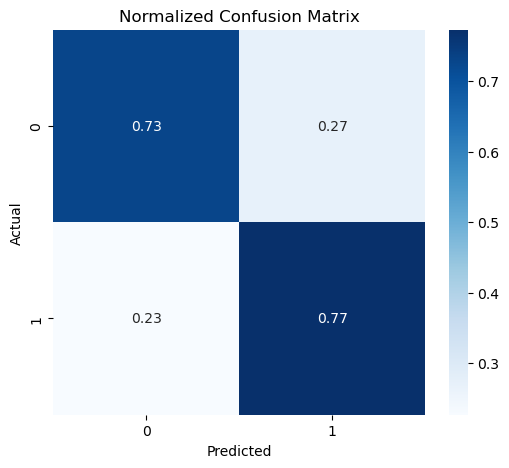

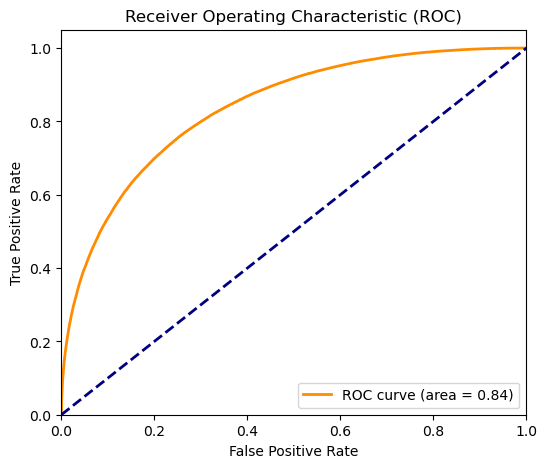

ROC AUC Score: 0.8360
CPU times: user 8min 21s, sys: 1min 4s, total: 9min 25s
Wall time: 8min 42s


In [8]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading, Splitting, and Scaling
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Scale features using StandardScaler
scaler = StandardScaler()
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
val_data[feature_columns]   = scaler.transform(val_data[feature_columns])
test_pd[feature_columns]    = scaler.transform(test_pd[feature_columns])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
# Note: hidden_dim1, hidden_dim2, hidden_dim3 are defined as globals and used in the model.
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 64      # adjust as needed
hidden_dim1 = 128    # adjust as needed
hidden_dim2 = 128    # adjust as needed
hidden_dim3 = 64     # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # improves performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
initial_lr = 0.001
min_lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Dynamic LR Reduction (patience = 1)
# ---------------------------
# ---------------------------
# 6. Training Loop with Dynamic LR Reduction and Early Stopping after 3 epochs with no improvement
# ---------------------------
num_epochs = 1000
best_val_roc_auc = 0.0
no_improve_count = 0  # Counter for consecutive epochs with no improvement

# Initialize lists for storing metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lrs = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation loop with ROC AUC calculation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    lrs.append(current_lr)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Check for improvement in validation ROC AUC and adjust LR if no improvement in this epoch
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
        no_improve_count = 0  # Reset counter on improvement
    else:
        no_improve_count += 1
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break
        
        # Check if there has been no improvement for 3 consecutive epochs
        if no_improve_count >= 3:
            print("No improvement in validation ROC AUC for 3 consecutive epochs. Stopping training.")
            break

# ---------------------------
# Plotting the Metrics
# ---------------------------
epochs_range = range(1, len(train_losses) + 1)

# Plot 1: Training Loss vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot 2: Training Accuracy vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot 3: Learning Rate Schedule
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, lrs, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


In [1]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import itertools

# ---------------------------
# 1. Data Loading, Splitting, and Scaling
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Scale features using StandardScaler
scaler = StandardScaler()
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
val_data[feature_columns]   = scaler.transform(val_data[feature_columns])
test_pd[feature_columns]    = scaler.transform(test_pd[feature_columns])

print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network with Variable Neurons per Layer
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

# ---------------------------
# 4. Define the Training and Evaluation Function
# ---------------------------
def train_and_evaluate(h_dims, num_epochs=10):
    """
    h_dims: tuple containing (hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3)
    num_epochs: number of training epochs for tuning (keep small for speed)
    Returns best validation ROC AUC achieved during training.
    """
    hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3 = h_dims
    input_dim = len(feature_columns)
    output_dim = 2  # binary classification

    # Initialize model, loss, optimizer
    model = NeuralNet(input_dim, hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # fixed learning rate

    best_val_roc_auc = 0.0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_labels = []
        val_probs = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                # Get probability for class 1
                probs = nn.functional.softmax(outputs, dim=1)[:, 1]
                val_probs.extend(probs.detach().cpu().numpy())
                val_labels.extend(y_batch.cpu().numpy())
        try:
            val_roc_auc = roc_auc_score(val_labels, val_probs)
        except ValueError:
            val_roc_auc = 0.0
        if val_roc_auc > best_val_roc_auc:
            best_val_roc_auc = val_roc_auc

    return best_val_roc_auc

# ---------------------------
# 5. Hyperparameter Tuning (Grid Search over Neuron Counts)
# ---------------------------
# Define candidate options for each layer's neuron count
hidden_dim_options   = [32, 64, 128, 144]
hidden_dim1_options  = [32, 64, 128, 144]
hidden_dim2_options  = [32, 64, 128, 144]
hidden_dim3_options  = [32, 64, 128, 144]

# Create grid of all possible combinations
hyperparameter_grid = list(itertools.product(hidden_dim_options,
                                             hidden_dim1_options,
                                             hidden_dim2_options,
                                             hidden_dim3_options))
print("Total hyperparameter combinations to try:", len(hyperparameter_grid))

# Dictionary to store results
results = {}

for h_dims in hyperparameter_grid:
    print(f"\nTraining with hyperparameters (hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3): {h_dims}")
    best_score = train_and_evaluate(h_dims, num_epochs=10)
    results[h_dims] = best_score
    print(f"  Best Validation ROC AUC: {best_score:.4f}")

# Find best hyperparameters based on validation ROC AUC
best_hyperparams = max(results, key=results.get)
print("\nBest Hyperparameters (hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3):", best_hyperparams)
print("Best Validation ROC AUC:", results[best_hyperparams])

# ---------------------------
# 6. (Optional) Train Final Model with Best Hyperparameters and Evaluate on Test Set
# ---------------------------
# Here you might retrain on the combined training and validation sets
# and finally evaluate on the test set.
# For brevity, the final training step is not shown here.


Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)
Total hyperparameter combinations to try: 256

Training with hyperparameters (hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3): (32, 32, 32, 32)


KeyboardInterrupt: 

In [1]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna

# ---------------------------
# 1. Data Loading, Splitting, and Scaling
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Scale features using StandardScaler
scaler = StandardScaler()
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
val_data[feature_columns]   = scaler.transform(val_data[feature_columns])
test_pd[feature_columns]    = scaler.transform(test_pd[feature_columns])

print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network with Variable Neurons per Layer
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

# ---------------------------
# 4. Define the Training and Evaluation Function
# ---------------------------
def train_and_evaluate(h_dims, num_epochs=10):
    """
    h_dims: tuple containing (hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3)
    num_epochs: number of training epochs for tuning (keep small for speed)
    Returns best validation ROC AUC achieved during training.
    """
    hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3 = h_dims
    input_dim = len(feature_columns)
    output_dim = 2  # binary classification

    # Initialize model, loss, optimizer
    model = NeuralNet(input_dim, hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # fixed learning rate

    best_val_roc_auc = 0.0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_labels = []
        val_probs = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # probability for class 1
                val_probs.extend(probs.detach().cpu().numpy())
                val_labels.extend(y_batch.cpu().numpy())
        try:
            val_roc_auc = roc_auc_score(val_labels, val_probs)
        except ValueError:
            val_roc_auc = 0.0
        if val_roc_auc > best_val_roc_auc:
            best_val_roc_auc = val_roc_auc

    return best_val_roc_auc

# ---------------------------
# 5. Hyperparameter Tuning via Bayesian Optimization using Optuna
# ---------------------------
def objective(trial):
    # Suggest values for each hyperparameter; here we choose from discrete options.
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128, 144])
    hidden_dim1 = trial.suggest_categorical("hidden_dim1", [32, 64, 128, 144])
    hidden_dim2 = trial.suggest_categorical("hidden_dim2", [32, 64, 128, 144])
    hidden_dim3 = trial.suggest_categorical("hidden_dim3", [32, 64, 128, 144])
    
    h_dims = (hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3)
    best_val_roc_auc = train_and_evaluate(h_dims, num_epochs=10)
    return best_val_roc_auc

# Create an Optuna study and optimize the objective function.
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # adjust n_trials as needed

print("\nBest Hyperparameters:")
print("\nBest Hyperparameters:")
print(study.best_trial.params)
print("Best Validation ROC AUC:", study.best_trial.value)

# ---------------------------
# 6. (Optional) Train Final Model with Best Hyperparameters and Evaluate on Test Set
# ---------------------------
# best_params = study.best_trial.params
# final_h_dims = (best_params["hidden_dim"], best_params["hidden_dim1"],
#                 best_params["hidden_dim2"], best_params["hidden_dim3"])

# You can now retrain the final model on the full training set (or combined training+validation) 
# using these best hyperparameters and then evaluate on the test set.


Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)


[I 2025-03-16 08:33:35,231] A new study created in memory with name: no-name-edb6aa00-68f1-41fc-8cd7-0468d025105f
[I 2025-03-16 08:38:13,274] Trial 0 finished with value: 0.8332436597419263 and parameters: {'hidden_dim': 64, 'hidden_dim1': 128, 'hidden_dim2': 128, 'hidden_dim3': 64}. Best is trial 0 with value: 0.8332436597419263.
[I 2025-03-16 08:42:49,728] Trial 1 finished with value: 0.8339780684735918 and parameters: {'hidden_dim': 64, 'hidden_dim1': 144, 'hidden_dim2': 144, 'hidden_dim3': 64}. Best is trial 1 with value: 0.8339780684735918.
[I 2025-03-16 08:47:25,718] Trial 2 finished with value: 0.8348520240420829 and parameters: {'hidden_dim': 144, 'hidden_dim1': 64, 'hidden_dim2': 32, 'hidden_dim3': 32}. Best is trial 2 with value: 0.8348520240420829.
[I 2025-03-16 08:51:58,363] Trial 3 finished with value: 0.8347256935889528 and parameters: {'hidden_dim': 128, 'hidden_dim1': 64, 'hidden_dim2': 144, 'hidden_dim3': 144}. Best is trial 2 with value: 0.8348520240420829.
[I 2025-03


Best Hyperparameters:
{'hidden_dim': 128, 'hidden_dim1': 144, 'hidden_dim2': 128, 'hidden_dim3': 64}
Best Validation ROC AUC: 0.8368355092174842
CPU times: user 3h 3min 38s, sys: 26min 15s, total: 3h 29min 53s
Wall time: 3h 7min 22s


In [7]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna

# ---------------------------
# 1. Data Loading, Splitting, and Scaling
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("higgs_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Scale features using StandardScaler
scaler = StandardScaler()
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
val_data[feature_columns]   = scaler.transform(val_data[feature_columns])
test_pd[feature_columns]    = scaler.transform(test_pd[feature_columns])

print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network with 5 Hidden Layers
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim4),
            nn.ReLU(),
            nn.Linear(hidden_dim4, hidden_dim5),
            nn.ReLU(),
            nn.Linear(hidden_dim5, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

# ---------------------------
# 4. Updated Training and Evaluation Function
# ---------------------------
def train_and_evaluate(h_dims, num_epochs=10):
    """
    h_dims: tuple containing (hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5)
    """
    hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5 = h_dims
    input_dim = len(feature_columns)
    output_dim = 2  # binary classification

    # Initialize model, loss, optimizer
    model = NeuralNet(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_roc_auc = 0.0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_labels = []
        val_probs = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                probs = nn.functional.softmax(outputs, dim=1)[:, 1]
                val_probs.extend(probs.detach().cpu().numpy())
                val_labels.extend(y_batch.cpu().numpy())
        try:
            val_roc_auc = roc_auc_score(val_labels, val_probs)
        except ValueError:
            val_roc_auc = 0.0
        if val_roc_auc > best_val_roc_auc:
            best_val_roc_auc = val_roc_auc

    return best_val_roc_auc

# ---------------------------
# 5. Corrected Hyperparameter Tuning via Optuna
# ---------------------------
def objective(trial):
    hidden_dim1 = trial.suggest_categorical("hidden_dim1", [112, 128, 144, 160, 176])
    hidden_dim2 = trial.suggest_categorical("hidden_dim2", [112, 128, 144, 160, 176])
    hidden_dim3 = trial.suggest_categorical("hidden_dim3", [112, 128, 144, 160, 176])
    hidden_dim4 = trial.suggest_categorical("hidden_dim4", [112, 128, 144, 160, 176])
    hidden_dim5 = trial.suggest_categorical("hidden_dim5", [112, 128, 144, 160, 176])
    
    h_dims = (hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5)
    best_val_roc_auc = train_and_evaluate(h_dims, num_epochs=10)
    return best_val_roc_auc

# Create an Optuna study and optimize the objective function.
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("\nBest Hyperparameters:")
print("\nBest Hyperparameters:")
print(study.best_trial.params)
print("Best Validation ROC AUC:", study.best_trial.value)

# ---------------------------
# 6. (Optional) Train Final Model with Best Hyperparameters and Evaluate on Test Set
# ---------------------------
# best_params = study.best_trial.params
# final_h_dims = (best_params["hidden_dim"], best_params["hidden_dim1"],
#                 best_params["hidden_dim2"], best_params["hidden_dim3"])

# You can now retrain the final model on the full training set (or combined training+validation) 
# using these best hyperparameters and then evaluate on the test set.


Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)


[I 2025-03-17 08:33:12,612] A new study created in memory with name: no-name-32527b8a-24cc-4aa7-a637-f06f60b1a3fd
[I 2025-03-17 08:40:43,084] Trial 0 finished with value: 0.835102384174343 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 112, 'hidden_dim3': 144, 'hidden_dim4': 144, 'hidden_dim5': 144}. Best is trial 0 with value: 0.835102384174343.
[I 2025-03-17 08:48:27,706] Trial 1 finished with value: 0.8342809183358812 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 112, 'hidden_dim3': 144, 'hidden_dim4': 176, 'hidden_dim5': 144}. Best is trial 0 with value: 0.835102384174343.
[I 2025-03-17 08:53:28,985] Trial 2 finished with value: 0.8364653672754268 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 112, 'hidden_dim3': 160, 'hidden_dim4': 128, 'hidden_dim5': 176}. Best is trial 2 with value: 0.8364653672754268.
[I 2025-03-17 08:57:04,655] Trial 3 finished with value: 0.8363751275121666 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 128, 'hidden_dim3': 128, 'hidden_di


Best Hyperparameters:

Best Hyperparameters:
{'hidden_dim1': 176, 'hidden_dim2': 128, 'hidden_dim3': 128, 'hidden_dim4': 128, 'hidden_dim5': 160}
Best Validation ROC AUC: 0.8382499732798193
CPU times: user 5h 55min 38s, sys: 53min 56s, total: 6h 49min 34s
Wall time: 6h 17s


---
# Complete Dataset
---

Dataset Shapes:
  Training set shape: (5866666, 29)
  Validation set shape: (1466667, 29)
  Test set shape: (3666667, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([128, 28])
net.0.bias: torch.Size([128])
net.2.weight: torch.Size([128, 128])
net.2.bias: torch.Size([128])
net.4.weight: torch.Size([128, 128])
net.4.bias: torch.Size([128])
net.6.weight: torch.Size([128, 128])
net.6.bias: torch.Size([128])
net.8.weight: torch.Size([2, 128])
net.8.bias: torch.Size([2])


Epoch 1/100: Train Loss: 0.53

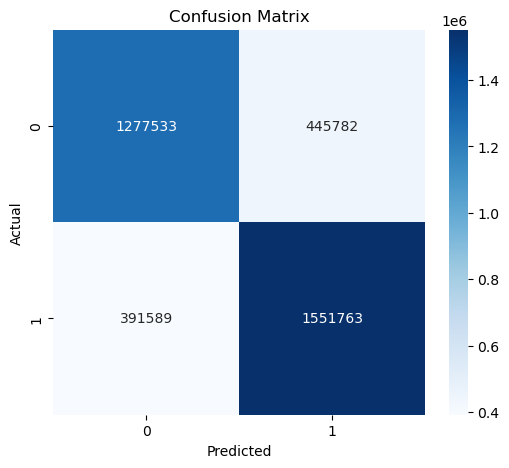

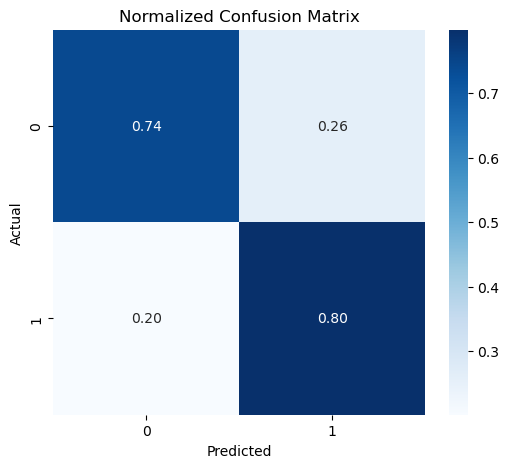

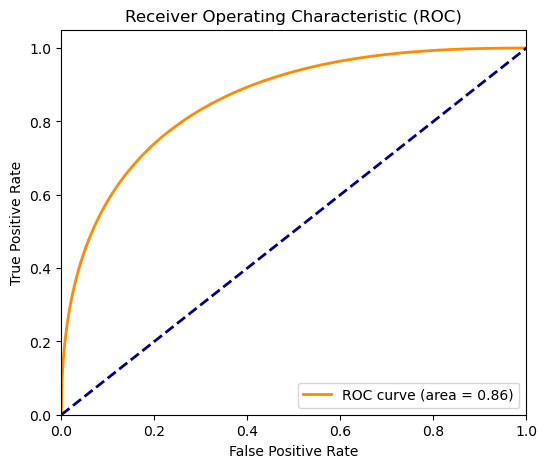

ROC AUC Score: 0.8567
CPU times: user 2h 18min 16s, sys: 22min 10s, total: 2h 40min 27s
Wall time: 2h 39min 25s


In [1]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Splitting
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("higgs_train.csv")
test_df = cudf.read_csv("higgs_test.csv")

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column = "class_label"

# Split train_pd into training and validation sets (80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 128      # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # improves performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
initial_lr = 0.001
min_lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Dynamic LR and Model Saving
# ---------------------------
num_epochs = 100
best_val_roc_auc = 0.0

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation loop with ROC AUC calculation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            # Get probability for the positive class (class index 1)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Check for improvement in validation ROC AUC
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
    else:
        # No improvement: reduce learning rate if above minimum
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


---
# Dataset Scaling
---

In [1]:
import cudf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1. Load Data with cuDF and Convert to Pandas
# ---------------------------
train_df = cudf.read_csv("higgs_train.csv")
test_df  = cudf.read_csv("higgs_test.csv")

train_pd = train_df.to_pandas()
test_pd  = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column   = "class_label"

# ---------------------------
# 2. Split Training Data (80-20 split for training and validation)
# ---------------------------
train_data, val_data = train_test_split(
    train_pd, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_pd[target_column]
)

# ---------------------------
# 3. Scale Features using StandardScaler
# ---------------------------
scaler = StandardScaler()
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
val_data[feature_columns]   = scaler.transform(val_data[feature_columns])
test_pd[feature_columns]    = scaler.transform(test_pd[feature_columns])

# ---------------------------
# 4. Save Scaled Datasets to CSV Files
# ---------------------------
train_data.to_csv("higgs_train_scaled.csv", index=False)
val_data.to_csv("higgs_val_scaled.csv", index=False)
test_pd.to_csv("higgs_test_scaled.csv", index=False)

print("Scaled datasets saved as 'higgs_train_scaled.csv', 'higgs_val_scaled.csv', and 'higgs_test_scaled.csv'.")


Scaled datasets saved as 'higgs_train_scaled.csv', 'higgs_val_scaled.csv', and 'higgs_test_scaled.csv'.



GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Epoch 1/1000: Train Loss: 0.5072 | Train Acc: 74.52% || Val Loss: 0.4896 | Val Acc: 75.70% | Val ROC AUC: 0.8410 || LR: 0.001000 | Time: 265.36 sec
--> New best model saved with Val ROC AUC: 0.8410
Epoch 2/1000: Train Loss: 0.4861 | Train Acc: 75.96% || Val Loss: 0.4828 | Val Acc: 76.17% | Val ROC AUC: 0.8455 || LR: 0.001000 | Time: 268.77 sec
--> New best model saved with Val ROC AUC: 0.8455
Epoch 3/1000: Train Loss: 0.4798 | Train Acc: 76.35% || Val Loss: 0.4802 | Val Acc: 76.48% | Val ROC AUC: 0.8490 || LR: 0.001000 | Time: 267.67 sec
--> New best model saved with Val ROC AUC: 0.8490
Epoch 4/1000: Train Loss: 0.4763 | Train Acc: 76.61% || Val Loss: 0.4748 | Val Acc: 76.68% | Val ROC AUC: 0.8512 || LR: 0.001000 | Time: 266.54 sec
--> New best model saved with Val ROC AUC: 0.8512
Epoch 5/1000: Train Loss: 0.4740 | Train Acc: 76.76% || Val Loss: 0.4749 | Val Acc: 76.70% | Val ROC AUC: 0.8518 || LR: 0.001000 | Time: 269.35 sec
--

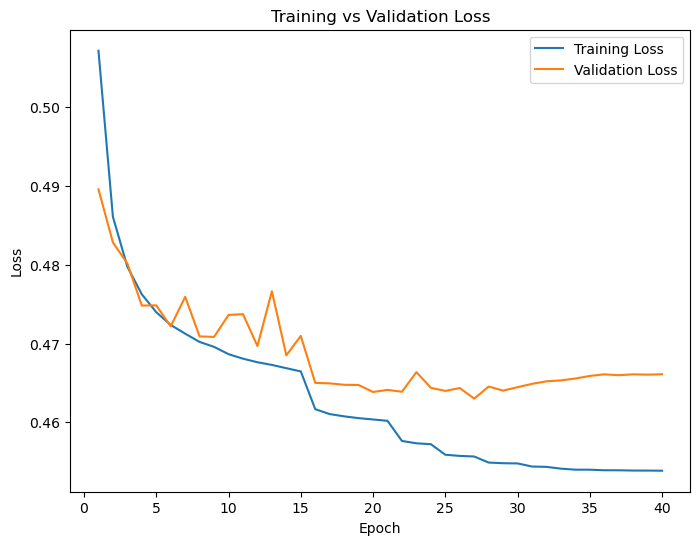

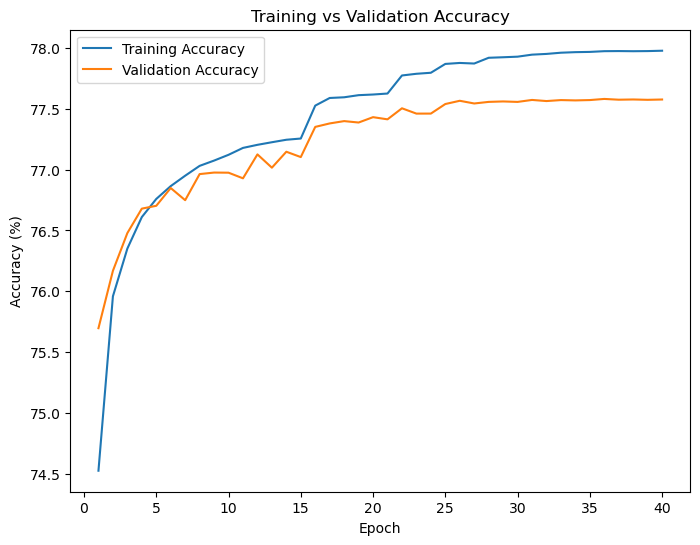

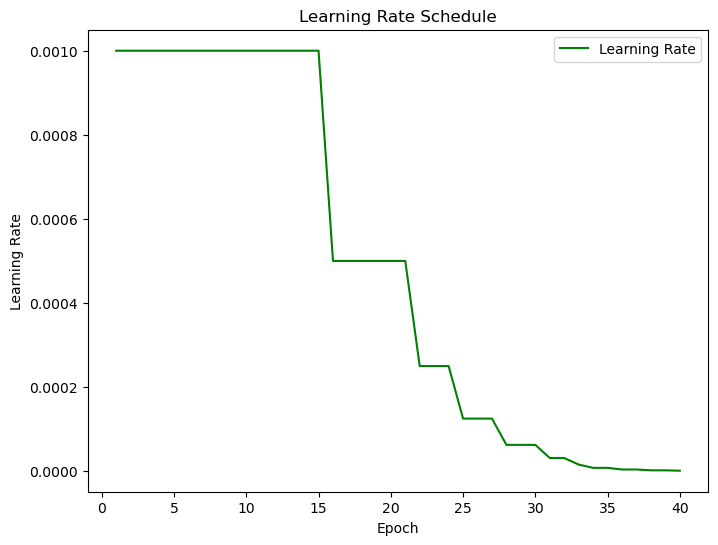

<timed exec>:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Set Evaluation:
  Test Loss: 0.4624
  Test Accuracy: 77.57%

Classification Report:
              precision    recall  f1-score   support

           0     0.7682    0.7487    0.7583   1723315
           1     0.7820    0.7997    0.7908   1943352

    accuracy                         0.7757   3666667
   macro avg     0.7751    0.7742    0.7746   3666667
weighted avg     0.7756    0.7757    0.7755   3666667



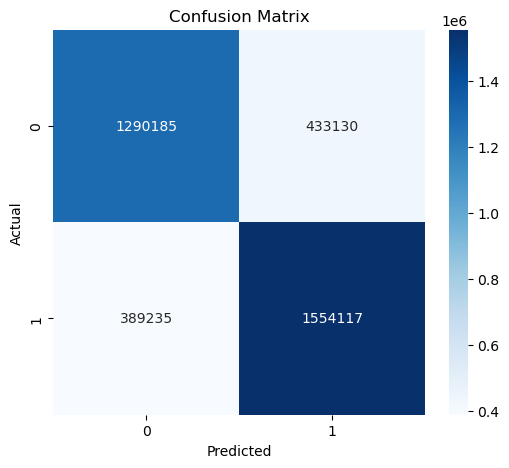

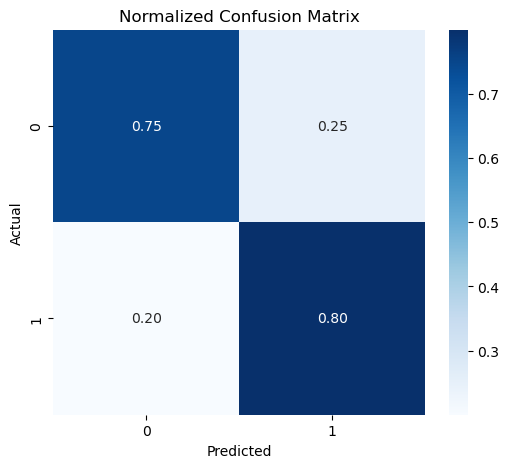

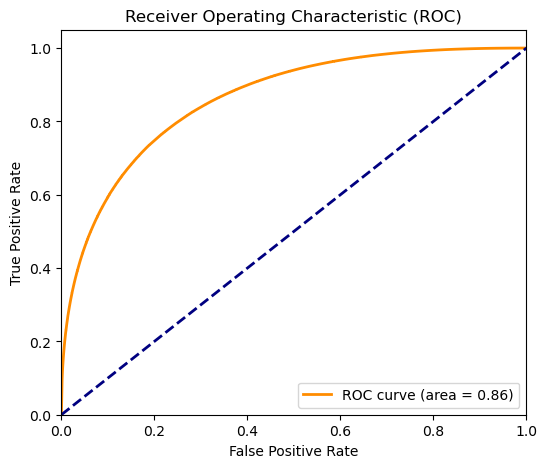

ROC AUC Score: 0.8611
CPU times: user 2h 34min 58s, sys: 25min 30s, total: 3h 28s
Wall time: 2h 59min 41s


In [1]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ---------------------------
# 1. Load Scaled Datasets from CSV
# ---------------------------
train_pd = pd.read_csv("higgs_train_scaled.csv")
val_pd   = pd.read_csv("higgs_val_scaled.csv")
test_pd  = pd.read_csv("higgs_test_scaled.csv")

feature_columns = train_pd.columns.drop("class_label")
target_column   = "class_label"

# ---------------------------
# 2. Create Custom PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects
train_dataset = CustomDataset(train_pd, feature_columns, target_column)
val_dataset   = CustomDataset(val_pd, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network Architecture
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 144      # adjust as needed
output_dim = 2        # binary classification (two classes)

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup Device and Optimizations
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

criterion   = nn.CrossEntropyLoss()
initial_lr  = 0.001
min_lr      = 1e-6
optimizer   = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5. Training Loop with Dynamic Learning Rate Reduction
# ---------------------------
num_epochs = 1000
best_val_roc_auc = 0.0

# Lists for storing metrics for plotting
train_losses    = []
val_losses      = []
train_accuracies= []
val_accuracies  = []
lrs             = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training step
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs  = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    lrs.append(current_lr)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Adjust learning rate if no improvement
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "higgs_best_model_144.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
    else:
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break

# ---------------------------
# 6. Plotting Metrics
# ---------------------------
epochs_range = range(1, len(train_losses) + 1)

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Learning Rate Schedule
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, lrs, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("higgs_best_model_144.pth"))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probabilities for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report and Confusion Matrix
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 9. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


Dataset Shapes:
  Training set shape: (5866666, 29)
  Validation set shape: (1466667, 29)
  Test set shape: (3666667, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Epoch 1/1000: Train Loss: 0.5083 | Train Acc: 74.45% || Val Loss: 0.4905 | Val Acc: 75.69% | Val ROC AUC: 0.8405 || LR: 0.001000 | Time: 361.27 sec
--> New best model saved with Val ROC AUC: 0.8405
Epoch 2/1000: Train Loss: 0.4867 | Train Acc: 75.91% || Val Loss: 0.4828 | Val Acc: 76.18% | Val ROC AUC: 0.8460 || LR: 0.001000 | Time: 265.25 sec
--> New best model saved with Val ROC AUC: 0.8460
Epoch 3/1000: Train Loss: 0.4804 | Train Acc: 76.32% || Val Loss: 0.4787 | Val Acc: 76.39% | Val ROC AUC: 0.8495 || LR: 0.001000 | Time: 260.47 sec
--> New best model saved with Val ROC AUC: 0.8495
Epoch 4/1000: Train Loss: 0.4769 | Train Acc: 76.56% || Val Loss: 0.4786 | Val Acc: 76.31% | Val ROC AUC: 0.8504 || LR: 0.001000 | Time: 264.32 sec
--> New best model saved with Val ROC AUC: 0.8504
Epoch 5/1000: Train Loss: 0.

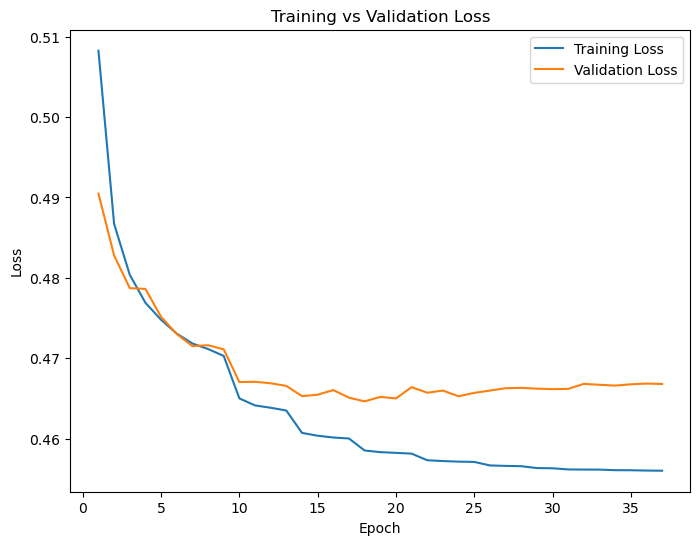

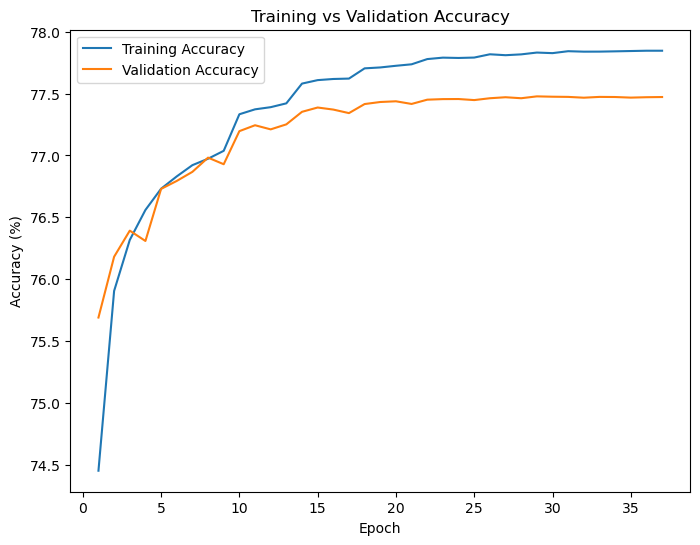

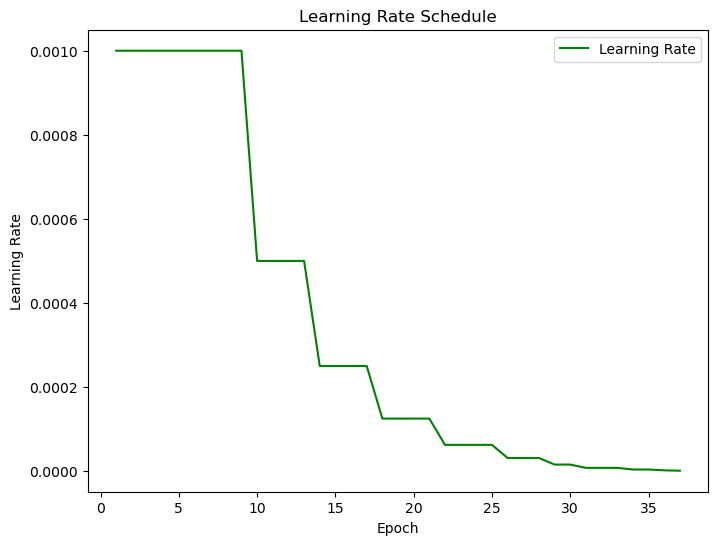


Test Set Evaluation:
  Test Loss: 0.4641
  Test Accuracy: 77.49%

Classification Report:
              precision    recall  f1-score   support

           0     0.7685    0.7458    0.7570   1723315
           1     0.7803    0.8008    0.7904   1943352

    accuracy                         0.7749   3666667
   macro avg     0.7744    0.7733    0.7737   3666667
weighted avg     0.7748    0.7749    0.7747   3666667



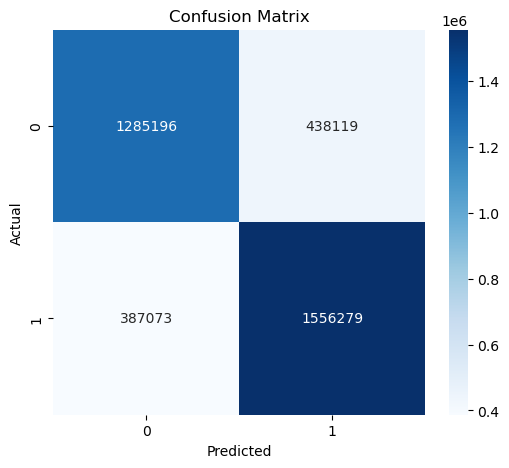

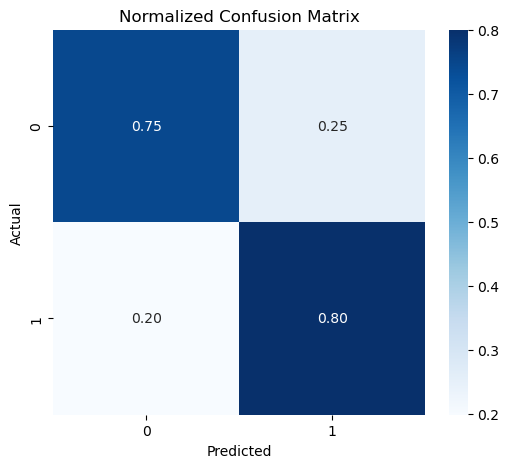

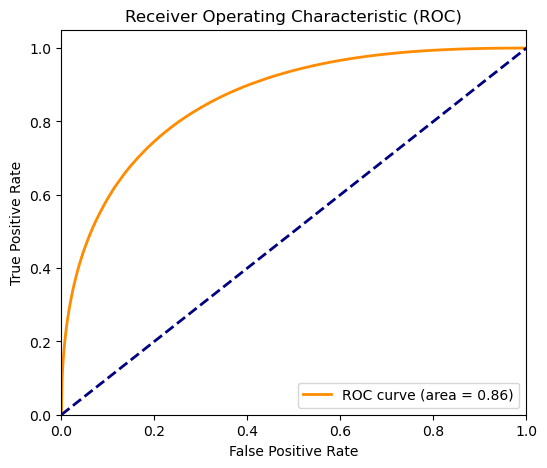

ROC AUC Score: 0.8600
CPU times: user 2h 25min 54s, sys: 23min 21s, total: 2h 49min 15s
Wall time: 2h 48min 27s


In [1]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ---------------------------
# 1. Load Scaled Datasets from CSV
# ---------------------------
train_pd = pd.read_csv("higgs_train_scaled.csv")
val_pd   = pd.read_csv("higgs_val_scaled.csv")
test_pd  = pd.read_csv("higgs_test_scaled.csv")

feature_columns = train_pd.columns.drop("class_label")
target_column   = "class_label"


# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_pd.shape)
print("  Validation set shape:", val_pd.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create Custom PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects
train_dataset = CustomDataset(train_pd, feature_columns, target_column)
val_dataset   = CustomDataset(val_pd, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network Architecture
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim4),
            nn.ReLU(),
            nn.Linear(hidden_dim4, hidden_dim5),
            nn.ReLU(),
            nn.Linear(hidden_dim5, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim1 = 176      
hidden_dim2 = 128      
hidden_dim3 = 128      
hidden_dim4 = 128      
hidden_dim5 = 160      
output_dim = 2        # binary classification (two classes)

# model = NeuralNet(input_dim, hidden_dim, output_dim)
model = NeuralNet(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

# ---------------------------
# 4. Setup Device and Optimizations
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

criterion   = nn.CrossEntropyLoss()
initial_lr  = 0.001
min_lr      = 1e-6
optimizer   = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5. Training Loop with Dynamic Learning Rate Reduction
# ---------------------------
num_epochs = 1000
best_val_roc_auc = 0.0

# Lists for storing metrics for plotting
train_losses    = []
val_losses      = []
train_accuracies= []
val_accuracies  = []
lrs             = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training step
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs  = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    lrs.append(current_lr)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Adjust learning rate if no improvement
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "higgs_best_model_144.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
    else:
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break

# ---------------------------
# 6. Plotting Metrics
# ---------------------------
epochs_range = range(1, len(train_losses) + 1)

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Learning Rate Schedule
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, lrs, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("higgs_best_model_144.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probabilities for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report and Confusion Matrix
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 9. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")
